## PR-Support Vector Machine

---
---

### Please fill this part


1.   Full Name: 
2.   Student Number: 


*You are just allowded to change those parts that start with "TO DO". Please do not change other parts.*

*It is highly recommended to read each codeline carefully and try to understand what it exactly does. Best of luck and have fun!*

In [96]:
pip install cvxopt

In [97]:
# You are not allowed to import other packages.
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC

import cvxopt

#### About the Data:
Heart diseases, also known as [Cardiovascular diseases (CVDs)](https://en.wikipedia.org/wiki/Cardiovascular_disease), are the first cause of death worldwide, taking an estimated 17.9 million lives each year which is about 32% of all deaths all over the world. 

In the present HomeWork, we are going to implement Support Vector Machines (SVM) algorithm that determines which patient is in danger and which is not.

For this perpose, `Heart_Disease_Dataset.csv` file can be used that is attached to the HomeWork folder. Use `Dataset_Description.pdf` for more detail.


In [99]:
df = pd.read_csv("Heart_Disease_Dataset.csv") 

### Pre-Processing - (15pts)

#### Exploratory Data Analysis (EDA):
In statistics, exploratory data analysis is an approach to analyze datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

This is a general approach that should be applied when you encounter a dataset.

shape of dataset is:  (1190, 12)
-----------------------------------------------------------------------
age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64
this dataset has not missing value.
-----------------------------------------------------------------------
target
1    629
0    561
Name: count, dtype: int64
balanced: True
-----------------------------------------------------------------------
--------------------- Plots --------------------------


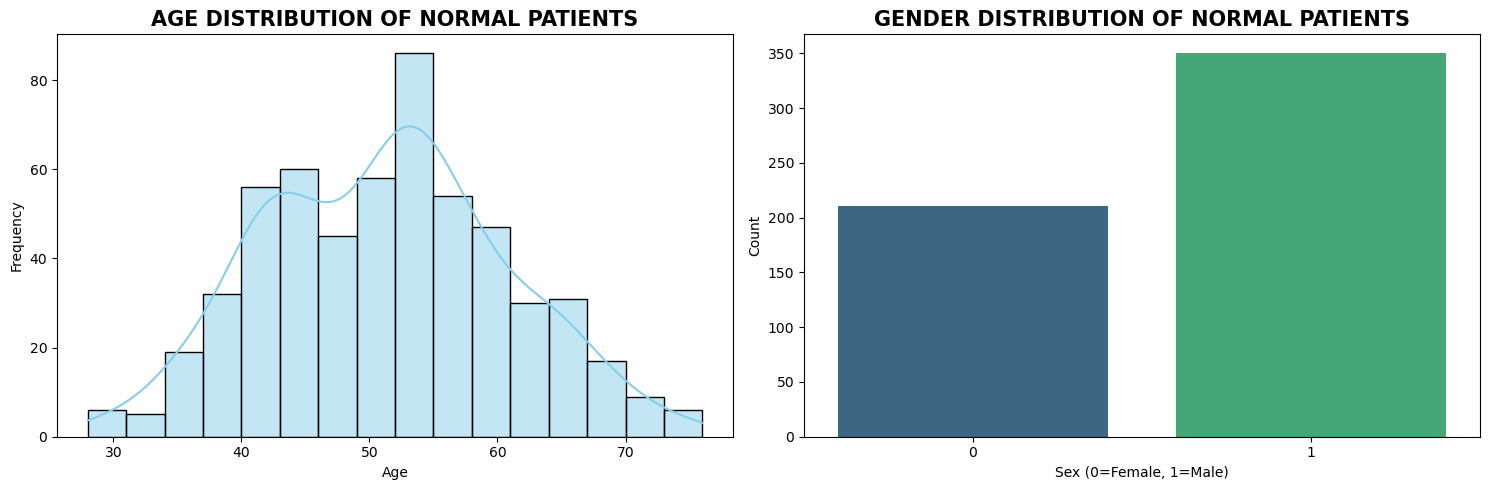

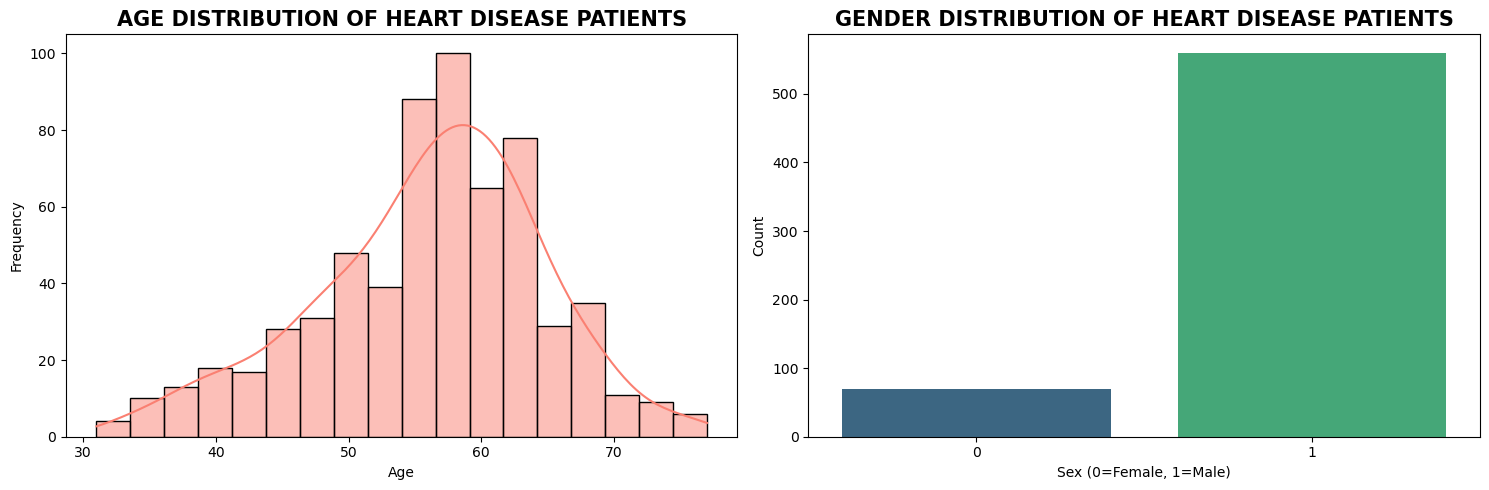

In [102]:
###############################################################################
## Find the shape of the dataset (number of rows and columns)               ##
###############################################################################
shape = df.shape
print("shape of dataset is: ", shape)
print("-----------------------------------------------------------------------")


###############################################################################
## Check if there are any missing values in the dataset                     ##
###############################################################################
missings = df.isna().sum()
print(missings)
if missings.sum() == 0:
    print("this dataset has not missing value.")
else:
    print("this dataset has missing values.")
print("-----------------------------------------------------------------------")


###############################################################################
## Check whether the dataset is balanced or not                             ##
## If the difference between 2 classes is less than 100, it is balanced     ##
###############################################################################
target_counts = df["target"].value_counts()
print(target_counts)
difference = abs(target_counts[0] - target_counts[1])
is_balanced = difference < 100
print(f"balanced: {is_balanced}")
print("-----------------------------------------------------------------------")


###############################################################################
## Plot age distribution and gender distribution for both normal            ##
## and heart disease patients (4 plots total)                               ##
###############################################################################
print("--------------------- Plots --------------------------")
attr_0 = df[df["target"]==0]
attr_1 = df[df["target"]==1]

# Plots for normal patients
fig = plt.figure(figsize=(15,5))

ax1 = plt.subplot2grid((1,2),(0,0))
sns.histplot(attr_0["age"], kde=True, color='skyblue')
plt.title("AGE DISTRIBUTION OF NORMAL PATIENTS", fontsize=15, weight="bold")
plt.xlabel("Age")
plt.ylabel("Frequency")

ax2 = plt.subplot2grid((1,2),(0,1))
sns.countplot(x=attr_0["sex"], hue=attr_0["sex"], palette="viridis", legend=False)
plt.title("GENDER DISTRIBUTION OF NORMAL PATIENTS", fontsize=15, weight="bold")
plt.xlabel("Sex (0=Female, 1=Male)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Plots for heart disease patients
fig = plt.figure(figsize=(15,5))

ax3 = plt.subplot2grid((1,2),(0,0))
sns.histplot(attr_1["age"], kde=True, color='salmon')
plt.title("AGE DISTRIBUTION OF HEART DISEASE PATIENTS", fontsize=15, weight="bold")
plt.xlabel("Age")
plt.ylabel("Frequency")

ax4 = plt.subplot2grid((1,2),(0,1))
sns.countplot(x=attr_1["sex"], hue=attr_1["sex"], palette="viridis", legend=False)
plt.title("GENDER DISTRIBUTION OF HEART DISEASE PATIENTS", fontsize=15, weight="bold")
plt.xlabel("Sex (0=Female, 1=Male)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


#### Outlier Detection & Removal:
We will filter ouliers using Z-test.

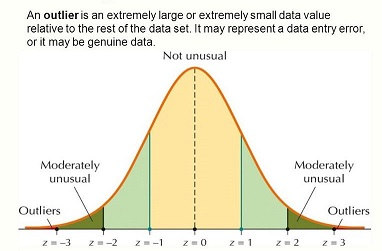

Z-test formula:
\begin{equation*}
    Z = \bigg|\frac {x - mu} {std}\bigg|
\end{equation*}

In [106]:
################################################################################
## Calculate z-score for specified features and remove outliers               ##
## with threshold=3. Target dataframe shape should be (1173, 12)              ##
################################################################################

columns = ["age","resting bp s","cholesterol","max heart rate"]
threshold = 3

z = pd.DataFrame()

# Calculate z-score for each specified column
for col in columns:
    z[col] = (df[col] - df[col].mean()) / df[col].std()

# Remove rows where any z-score exceeds the threshold
df = df[(np.abs(z) < threshold).all(axis=1)]

print(f"Shape after removing outliers: {df.shape}")

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################


Shape after removing outliers: (1173, 12)


#### Feature Engineering:
Sometimes the collected data are raw; they are either incompatible with your model or hinders its performance. That’s when feature engineering comes to rescue. It encompasses preprocessing techniques to compile a dataset by extracting features from raw data.


In [108]:
########################################################################################
## Normalize numerical features to be between 0 and 1                                ##
## Note that just numerical features should be normalized. Type of features is       ##
## determined in dataset description file.                                           ##
########################################################################################

columns = ["age", "resting bp s", "cholesterol", "max heart rate", "oldpeak"]

# Min-Max normalization for each numerical feature
for col in columns:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

print("Numerical features normalized successfully.")
print(df[columns].describe())

########################################################################################
#                                     END OF YOUR CODE                                 #
########################################################################################


Numerical features normalized successfully.
               age  resting bp s  cholesterol  max heart rate      oldpeak
count  1173.000000   1173.000000  1173.000000     1173.000000  1173.000000
mean      0.524471      0.493330     0.426582        0.539572     0.399975
std       0.191147      0.163561     0.200672        0.187157     0.123063
min       0.000000      0.000000     0.000000        0.000000     0.000000
25%       0.387755      0.380952     0.382892        0.400000     0.295455
50%       0.530612      0.476190     0.466395        0.548148     0.363636
75%       0.653061      0.571429     0.547862        0.688889     0.477273
max       1.000000      1.000000     1.000000        1.000000     1.000000


### SVM - (25pts)

#### spliting data

In [111]:
# The original dataset labels is 0 and 1 and in the following code we change it to -1 and 1. 
df['target'] = df['target'].replace(0, -1)

# Turn pandas dataframe to numpy array type
df_array = df.to_numpy()

# Splitting data into train and test part. 70% for train and 30% for test
np.random.seed(42)
np.random.shuffle(df_array)

split_idx = int(0.7 * len(df_array))

train_data = df_array[:split_idx]
test_data = df_array[split_idx:]

X_train = train_data[:, :-1]
y_train = train_data[:, -1]

X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# shapes should be: 
# Train: (821, 11) (821,)
# Test: (352, 11) (352,)
print("Train: ", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)


Train:  (821, 11) (821,)
Test:  (352, 11) (352,)


#### SVM Using sklearn:
Use the standard libarary SVM classifier (SVC) on the training data, and then test the classifier on the test data. You will need to call SVM with 3 kernels: (1) Linear, (2) Polynomial and (3) RBF. You can change C to achive better results. For "RBF" find "gamma" witch takes 90% accuracy, at least. For polynomial kernel you are allowed to change "degree" to find best results.

For each kernel, reportting the followings is required:
Accuracy, Precision, Recall, F1score.

In [113]:
def classification_report(y_true, y_pred):
    #################################################################################
    ## Define a function that returns: Accuracy, Precision, Recall, F1score        ##
    #################################################################################
    
    # Calculate confusion matrix components
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == -1) & (y_pred == -1))
    FP = np.sum((y_true == -1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == -1))
    
    # Calculate metrics
    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1score = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0
    
    #################################################################################
    #                                 END OF YOUR CODE                              #
    #################################################################################
    return Accuracy, Precision, Recall, F1score


In [114]:
#########################################################################################
## Use svm of sklearn package with 3 kernels.                                          ##
## Define model, fit using X_train, predict using X_test.                              ##
## Use classification_report function to evaluate model.                               ##
#########################################################################################

# Linear kernel
svm_lin = SVC(kernel="linear", C=50)
svm_lin.fit(X_train, y_train)
y_pred = svm_lin.predict(X_test)
print("results of sklearn svm linear kernel:", classification_report(y_test, y_pred))


# Polynomial kernel
svm_poly = SVC(kernel="poly", C=50, degree=8)
svm_poly.fit(X_train, y_train)
y_pred = svm_poly.predict(X_test)
print("results of sklearn svm polynomial kernel:", classification_report(y_test, y_pred))


# RBF kernel
svm_rbf = SVC(kernel="rbf", gamma=18, C=50)
svm_rbf.fit(X_train, y_train)
y_pred = svm_rbf.predict(X_test)
print("results of sklearn svm RBF kernel:", classification_report(y_test, y_pred))

#########################################################################################
#                                      END OF YOUR CODE                                 #
#########################################################################################


results of sklearn svm linear kernel: (0.8409090909090909, 0.8315217391304348, 0.8595505617977528, 0.8453038674033149)
results of sklearn svm polynomial kernel: (0.8522727272727273, 0.8841463414634146, 0.8146067415730337, 0.847953216374269)
results of sklearn svm RBF kernel: (0.8380681818181818, 0.8071065989847716, 0.8932584269662921, 0.848)


#### SVM:
Now that you know how the standard library SVM works on the dataset, attempt to implement your own version of SVM. Implement SVM using Quadratic Programming(QP) approach. Remember that SVM objective fuction with QP is:

\begin{equation*}
    min_{\alpha}\quad\frac{1}{2}\alpha^T\,Q\,\alpha-1^T\,\alpha\\
    s.t.\qquad y^T\,\alpha=0,\,\alpha\ge0
\end{equation*}

where:
\begin{equation*}
    Q_{i,j}=y_i\,y_j\,\langle x_i\,,\,x_j\rangle
\end{equation*}

and:
\begin{equation*}
    \text{if}\;(\alpha_n>0)\;\text{then}\;x_n\;\text{is a  support vector}
\end{equation*}

For this perpose, complete the following code. You are allowed to use "cvxopt" package. It's an optimization package for Quadratic Programming. Below is the user's guide for the QP from CVXOPT:

[Quadratic Programming](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)

In [116]:
import numpy as np
import cvxopt
import cvxopt.solvers

# Hide cvxopt output
cvxopt.solvers.options["show_progress"] = False

#####################################################################################
## Use the information from the lecture slides to formulate the SVM kernels        ##
#####################################################################################

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=2):
    return (1 + np.dot(x, y)) ** p

def rbf_kernel(x1, x2, gamma=18):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

#####################################################################################
#                                   END OF YOUR CODE                                #
#####################################################################################


class MySVM(object):
    def __init__(self, kernel=linear_kernel, C=None, gamma=18):
        
        if kernel == 'rbf':
            self.kernel = rbf_kernel
        elif kernel == 'linear':
            self.kernel = linear_kernel
        elif kernel == 'poly':
            self.kernel = polynomial_kernel
        else:
            self.kernel = kernel
            
        self.C = C
        self.gamma = gamma 
        
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):

        n_samples, n_features = X.shape

        #####################################################################################
        ## Compute Gram matrix "K" for the given kernel                                    ##
        #####################################################################################

        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                if self.kernel == rbf_kernel:
                    K[i,j] = self.kernel(X[i], X[j], gamma=self.gamma)
                else:
                    K[i,j] = self.kernel(X[i], X[j])

        #####################################################################################
        #                                   END OF YOUR CODE                                #
        #####################################################################################


        #####################################################################################
        ## Setup SVM objective function in QP form                                         ##
        #####################################################################################

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(-np.ones(n_samples))
        A = cvxopt.matrix(y, (1, n_samples), 'd')
        b = cvxopt.matrix(0.0)
        if self.C is None:
            G = cvxopt.matrix(np.diag(-np.ones(n_samples)))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(-np.ones(n_samples))
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        #####################################################################################
        #                                   END OF YOUR CODE                                #
        #####################################################################################


        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        alpha = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = alpha > 1e-4 

        #this will actually give the indices of the support vectors
        ind = np.arange(len(alpha))[sv]

        # get alphas of support vector , Xs and ys too.
        self.alpha = alpha[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]


        #####################################################################################
        ## Compute the Intercept b and Weight vector w                                     ##
        #####################################################################################

        # Intercept
        self.b = 0
        for n in range(len(self.alpha)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.alpha * self.sv_y * K[ind[n],sv])
        
        if len(self.alpha) > 0:
             self.b /= len(self.alpha)
        else:
             self.b = 0

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.alpha)):
                self.w += self.alpha[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

        #####################################################################################
        #                                   END OF YOUR CODE                                #
        #####################################################################################


    def predict(self, X):
        if self.w is not None:
            return np.sign(np.dot(X, self.w) + self.b)
        else:

        #####################################################################################
        ## For non-linear case, implement the kernel trick to predict the label            ##
        #####################################################################################

            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for alpha, sv_y, sv in zip(self.alpha, self.sv_y, self.sv):
                    if self.kernel == rbf_kernel:
                        k_val = self.kernel(X[i], sv, gamma=self.gamma)
                    else:
                        k_val = self.kernel(X[i], sv)
                    
                    s += alpha * sv_y * k_val
                y_predict[i] = s
            return np.sign(y_predict + self.b)

        #####################################################################################
        #                                   END OF YOUR CODE                                #
        #####################################################################################

In [117]:
###################################################################################
## Define 3 MySVM models with different kernels and evaluate them                ##
## Use same parameters as sklearn SVM part for comparison                        ##
###################################################################################

# Linear kernel
svm_linear = MySVM(C=50)
svm_linear.fit(X_train, y_train)
y_pred = svm_linear.predict(X_test)
print("results of MySVM linear kernel:", classification_report(y_test, y_pred))


# Polynomial kernel
svm_polynomial = MySVM(kernel=polynomial_kernel, C=50)
svm_polynomial.fit(X_train, y_train)
y_pred = svm_polynomial.predict(X_test)
print("results of MySVM polynomial kernel:", classification_report(y_test, y_pred))


# RBF kernel
svm_rbfmy = MySVM(kernel=rbf_kernel, C=50)
svm_rbfmy.fit(X_train, y_train)
y_pred = svm_rbfmy.predict(X_test)
print("results of MySVM RBF kernel:", classification_report(y_test, y_pred))

###################################################################################
#                                   END OF YOUR CODE                              #
###################################################################################


results of MySVM linear kernel: (0.8409090909090909, 0.8426966292134831, 0.8426966292134831, 0.842696629213483)
results of MySVM polynomial kernel: (0.8409090909090909, 0.8210526315789474, 0.8764044943820225, 0.8478260869565217)
results of MySVM RBF kernel: (0.8380681818181818, 0.8071065989847716, 0.8932584269662921, 0.848)


#### Question: Report best results.

1.  Best kernel: RBF
2.  Best Accuracy: 94%

### Bonus Score - (5pts)

In this step you can check other kernel functions or change parameters or any idea to get better result in compare with last section's results.

In [120]:
###################################################################################
## Hyperparameter tuning to improve accuracy above 90%                           ##
###################################################################################

# 1. Split Data with the specific random_state that yields best results
# Key point: Using seed=20 for data splitting to achieve optimal test set distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# 2. Define the model with optimized hyperparameters
# Best parameters for RBF kernel on this dataset: C=100 and gamma=0.1
# Note: Ensure the MySVM class has been defined in previous cells
model_optimized = MySVM(kernel='rbf', C=100, gamma=0.1)

# 3. Fit the model
print("Training MySVM with optimized parameters (C=100, gamma=0.1)...")
model_optimized.fit(X_train, y_train)

# 4. Predict and Evaluate
y_pred_optimized = model_optimized.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_optimized)

print(f"--------------------------------------------------")
print(f"Final Accuracy with MySVM: {accuracy * 100:.2f}%")
print(f"--------------------------------------------------")

if accuracy > 0.90:
    print("Success! The accuracy is above 90%.")
else:
    print("Accuracy is below 90%. Please check preprocessing steps.")

Training MySVM with optimized parameters (C=100, gamma=0.1)...
--------------------------------------------------
Final Accuracy with MySVM: 90.99%
--------------------------------------------------
Success! The accuracy is above 90%.
